We will be creating a recommendation engine using data sourced from https://www.kaggle.com/datasets/tamber/steam-video-games. 

The dataset is described as ....

The codes in this notebook were patterned after the Movie Recommendations jupyter notebook by sventurina found in https://github.com/UPStat280/01-recommender-systems/blob/main/recommender-v2.ipynb.

# I. Loading Libraries

In [2]:
# Loading Libraries
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pylab as plt

from sklearn.neighbors import NearestNeighbors

from surprise import SVD
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# II. Data Preparation

In [27]:
anime_df = pd.read_csv(r"C:\Users\Bryan\Documents\Files\h u s t l e\grad school\PMDSA\2.0 [2024] Second Semester\Stat280 (Practical Machine Learning)\00 Datasets\anime.csv")
anime_ratings_df = pd.read_csv(r"C:\Users\Bryan\Documents\Files\h u s t l e\grad school\PMDSA\2.0 [2024] Second Semester\Stat280 (Practical Machine Learning)\00 Datasets\anime - rating.csv")

In [28]:
anime_df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [29]:
anime_ratings_df

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


# III. Exploratory Data Analysis

In [40]:
# Getting unique numbers of users and animes included in the dataset

num_anime = len(anime_df.anime_id.unique())
num_users= len(anime_ratings_df.user_id.unique())
print('There are {} unique users and {} unique animes in this data set'.format(num_users, num_anime))

There are 73515 unique users and 12294 unique animes in this data set


,anime_id
count,73515.000000
mean,106.287656
std,153.086558
min,1.000000
25%,18.000000
50%,57.000000
75%,136.000000
max,10227.000000


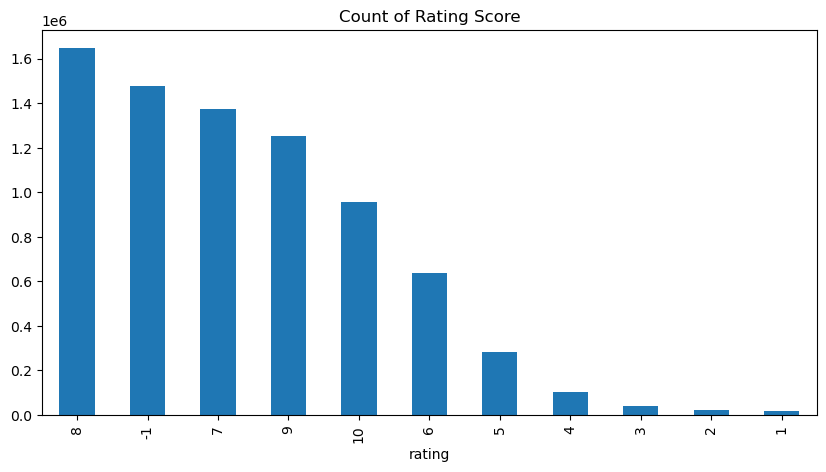

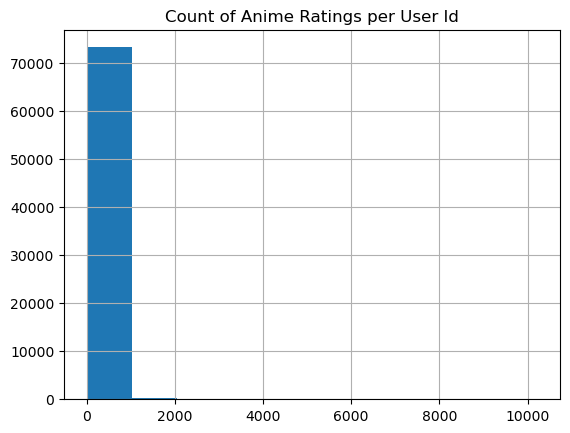

In [45]:
#How many ratings per User ID do we have?

#look at ratings distribution

anime_ratings_df['rating'].value_counts().plot.bar(title="Count of Rating Score",figsize=(10,5))
anime_ratings_df[['user_id','anime_id']].groupby(['user_id']).count().hist()
plt.title("Count of Anime Ratings per User Id")
anime_ratings_df[['user_id','anime_id']].groupby(['user_id']).count().describe()

Notice that there are large proportion of anime ratings tagged as -1, which indicate that there are large proportion of user_id have yet to watch some anime. In order to reflect the count of anime ratings given by the users, a we need to split the dataset based on the ratings. 

In [50]:
anime_ratings_df1 = anime_ratings_df[anime_ratings_df['rating'] != -1]
anime_ratings_df1

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


,anime_id
count,69600.000000
mean,91.052313
std,135.764253
min,1.000000
25%,13.000000
50%,45.000000
75%,114.000000
max,3747.000000


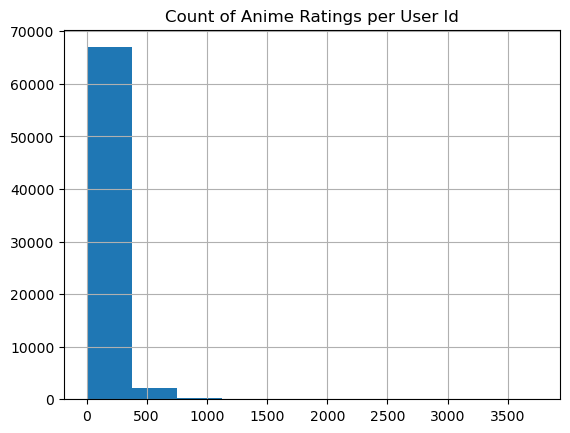

In [51]:
anime_ratings_df1[['user_id','anime_id']].groupby(['user_id']).count().hist()
plt.title("Count of Anime Ratings per User Id")
anime_ratings_df1[['user_id','anime_id']].groupby(['user_id']).count().describe()

In general, there an about 69,600 unique users that leave anime reviews

,user_id
count,9927.000000
mean,638.384305
std,1795.865541
min,1.000000
25%,9.000000
50%,57.000000
75%,395.000000
max,34226.000000


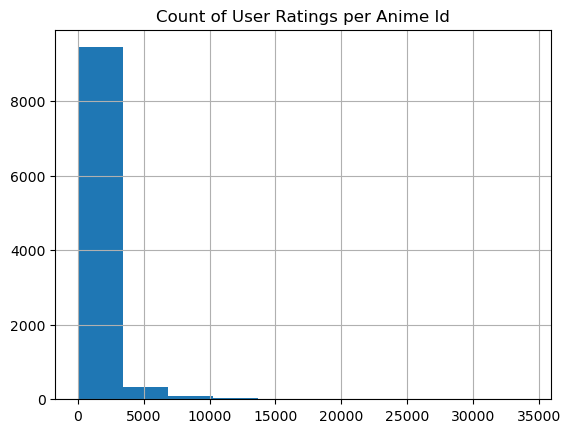

In [55]:
# How many user ratings per anime id do we have? 

anime_ratings_df1[['user_id','anime_id']].groupby(['anime_id']).count().hist()
plt.title("Count of User Ratings per Anime Id")
anime_ratings_df1[['user_id','anime_id']].groupby(['anime_id']).count().describe()

<Axes: title={'center': 'Count of Rating Score'}, xlabel='rating'>

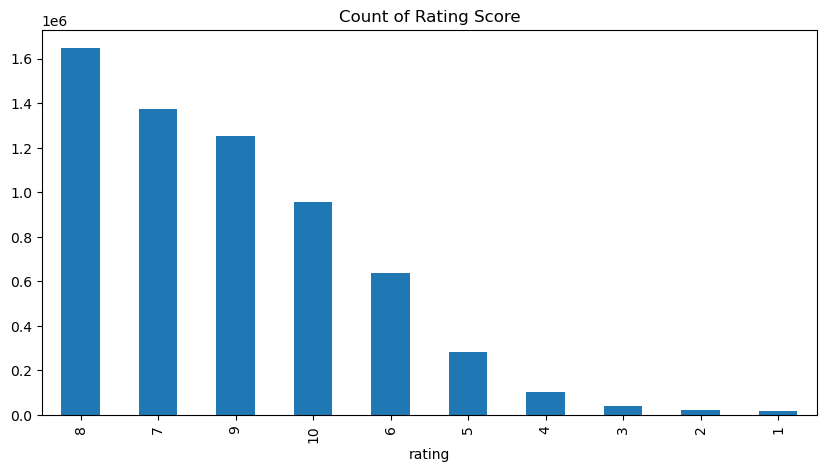

In [56]:
anime_ratings_df1['rating'].value_counts().plot.bar(title="Count of Rating Score",figsize=(10,5))

An average anime has around 638 ratings, with the median (which can be described to be the animes which enjoy a relatively average popularity) at around 57 ratings. Popular animes, as expected, receive high numbers of ratings, with the maximum at 34,226 ratings. 

The ratings, however, reflect that most ratings are actually high, with the top ratings (6-10) are also the more common instances. That is, lower ratings are not that usually given.

# IV. Preprocessing

Taking our EDA into consideration, set popularity theshold and active user thresholds for optimization purposes.

In [80]:
popularity_thres = 10
anime_rating_cnt_df = anime_ratings_df1[['rating','anime_id']].groupby(['anime_id']).count()
popular_anime_df = anime_rating_cnt_df[anime_rating_cnt_df['rating']>=popularity_thres]


filtered_anime_df = anime_ratings_df1[anime_ratings_df1.anime_id.isin(popular_anime_df.index.values)]
print('shape of original ratings data: ', anime_ratings_df1.shape)
print('shape of ratings data after dropping unpopular movies: ', filtered_anime_df.shape)


shape of original ratings data:  (7813737, 3)
shape of ratings data after dropping unpopular movies:  (6328961, 3)


In [82]:
#filtering for active users
ratings_thres = 5 
#max_thres= 500

active_users_cnt_df = anime_ratings_df[['user_id','anime_id']].groupby(['user_id']).count()
active_users_df = active_users_cnt_df[active_users_cnt_df['anime_id']>=ratings_thres]

#active_users_df = active_users_cnt_df[(active_users_cnt_df['movieId']>=ratings_thres)& (active_users_cnt_df['movieId']< max_thres) ]

#display(active_users_df) 

filtered_popular_active_df = filtered_anime_df[filtered_anime_df.index.isin(active_users_df.index.values)]
print('shape of original ratings data: ', filtered_anime_df.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', filtered_popular_active_df.shape)

shape of original ratings data:  (6328961, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (53682, 3)


In [83]:
filtered_popular_active_df

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
153,2,11771,10
156,3,20,8
157,3,154,6
...,...,...,...
73510,765,14741,9
73511,765,14833,9
73512,765,15117,9
73513,765,15225,9


In [84]:
# Let's transform this into a anime-user pivot table
# Let's join them up first using a left join operation on movieId

filtered_anime_ratings_merged_df = pd.merge(filtered_popular_active_df,anime_df, how='left', on=['anime_id'])
filtered_anime_ratings_merged_df.head()

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660
2,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315
3,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
4,3,154,6,Shaman King,"Action, Adventure, Comedy, Drama, Shounen, Sup...",TV,64,7.83,169517


In [85]:
filtered_anime_ratings_merged_df

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660
2,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315
3,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
4,3,154,6,Shaman King,"Action, Adventure, Comedy, Drama, Shounen, Sup...",TV,64,7.83,169517
...,...,...,...,...,...,...,...,...,...
53677,765,14741,9,Chuunibyou demo Koi ga Shitai!,"Comedy, Drama, Romance, School, Slice of Life",TV,12,7.95,394399
53678,765,14833,9,Maoyuu Maou Yuusha,"Adventure, Demons, Fantasy, Historical, Romance",TV,12,7.44,164445
53679,765,15117,9,Kami nomi zo Shiru Sekai: Tenri-hen,"Comedy, Harem, Romance, Shounen, Supernatural",OVA,2,7.85,68623
53680,765,15225,9,Hentai Ouji to Warawanai Neko.,"Comedy, Harem, Romance, School, Seinen, Supern...",TV,12,7.46,201735


In [86]:
# Now let's pivot the dataframe such that it will have anime_id as the index, and user_id as columns
filtered_anime_ratings_df = pd.pivot(filtered_anime_ratings_merged_df,index='anime_id', columns='user_id', values='rating_x').fillna(0)
filtered_anime_ratings_df.head()

user_id,1,2,3,5,7,8,9,10,11,12,...,755,756,757,758,759,760,762,763,764,765
anime_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
filtered_anime_ratings_df

user_id,1,2,3,5,7,8,9,10,11,12,...,755,756,757,758,759,760,762,763,764,765
anime_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
filtered_anime_ratings_df.describe()

user_id,1,2,3,5,7,8,9,10,11,12,...,755,756,757,758,759,760,762,763,764,765
count,4066.000000,4066.000000,4066.000000,4066.00000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,...,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000,4066.000000
mean,0.004919,0.002459,0.156911,0.44786,0.555337,0.022135,0.001968,0.006886,0.186178,0.043040,...,0.007378,0.007132,0.051648,0.098377,0.270044,0.000246,0.371618,0.079931,0.002213,0.093458
std,0.221757,0.156825,1.096779,1.52901,1.967263,0.431824,0.125460,0.253782,1.173934,0.617392,...,0.271563,0.262823,0.674095,0.926400,1.458528,0.015683,1.717967,0.764048,0.141143,0.906785
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,8.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,10.000000,10.000000,9.000000,10.000000


In [95]:
# Sparse Matrix
anime_ratings_mat = csr_matrix(filtered_popular_active_df.values)
anime_ratings_mat

<53682x3 sparse matrix of type '<class 'numpy.int64'>'
	with 161046 stored elements in Compressed Sparse Row format>

# V. Modelling

## V.A. Memory-Based Approach

 Metric is the distance algorithm to be used. You can find more choices here: 
  https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetris_mat)

In [101]:
# algorithm is the type of tree search used by the model
# neighbors it the amount of neighbors identified
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

model_knn.fit(anime_ratings_mat)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [102]:
# Let's try it out
fav_movie = "School"
print('You have input movie:', fav_movie)

# find movies that "match" title
anime_matches_df = filtered_anime_ratings_merged_df[filtered_anime_ratings_merged_df['name'].str.contains(fav_movie)]  
anime_matches_df

You have input movie: School


,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
1,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660
94,5,24,1,School Rumble,"Comedy, Romance, School, Shounen",TV,26,8.06,178553
145,5,517,3,School Rumble Ichi Gakki Hoshuu,"Comedy, Romance, School, Shounen",OVA,2,7.85,40868
155,5,846,1,School Rumble Ni Gakki,"Comedy, Romance, School, Shounen",TV,26,8.15,93095
219,5,4015,1,School Rumble San Gakki,"Comedy, Romance, School, Shounen",OVA,2,7.38,41898
...,...,...,...,...,...,...,...,...,...
53625,763,13357,7,High School DxD Specials,"Comedy, Demons, Ecchi, Harem, Romance, School",Special,6,7.37,75439
53627,763,15451,7,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.87,266657
53671,765,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660
53675,765,13357,10,High School DxD Specials,"Comedy, Demons, Ecchi, Harem, Romance, School",Special,6,7.37,75439


In [106]:
print("Let's start making recommendations!...")

if(anime_matches_df is  None):
    print("No Matching movies :(")
else:
    # Indicate the top recommendations we want to get (how many neighbors should we find?)
    top_recommendations = 10

    anime_idx= anime_matches_df.iloc[0]['anime_id'] # select the first anime in the list, get the anime_id
    
    # get the dataframe index from the anime_id
    anime_idx = filtered_anime_ratings_merged_df[filtered_anime_ratings_merged_df['anime_id'] == anime_idx].index[0]

    # model will return a list of distances and indices
    distances , indices = model_knn.kneighbors(anime_ratings_mat[anime_idx],n_neighbors=top_recommendations+1)    

    # transform the result into a list
    rec_anime_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
    recommend_frame = [] #let's create an empty list
 
    # we will iterate thru the results and add them to the list
    for val in rec_anime_indices:
        
        # we get the movie id
        anime_idx = filtered_anime_ratings_merged_df.iloc[val[0]]['anime_id']
        # convert into an index, we will this use to get the movie title
        idx = filtered_anime_ratings_merged_df[filtered_anime_ratings_merged_df['anime_id'] == anime_idx].index
        # take the movie title together with the computed "distance". This distance is how far the anime are from the 'target' anime
        recommend_frame.append({'Title':filtered_anime_ratings_merged_df.iloc[idx]['name'].values[0],'Distance':val[1]})

    # place resulting list inside a dataframe
    df = pd.DataFrame(recommend_frame,index=range(1,top_recommendations+1))
    display(df.sort_values("Distance")) #sort by distance to get the top 10

Let's start making recommendations!...


,Title,Distance
10,Kuroko no Basket,3.577009e-09
9,Kuroko no Basket,1.430724e-08
8,Sword Art Online,1.883671e-08
7,Magi: The Labyrinth of Magic,2.202831e-08
6,Inazuma Eleven Go,2.482998e-08
5,Ao no Exorcist,2.488064e-08
4,Hoshi wo Ou Kodomo,2.636630e-08
3,Another,2.682598e-08
2,Fullmetal Alchemist: The Sacred Star of Milos,3.382842e-08
1,Shingeki no Kyojin,3.701416e-08


In [108]:
# Let's use surprise library to get a measure of our knn model's RMSE metric
# The Reader class is used to parse a file containing ratings.
# A reader is still needed but only the rating_scale param is required.

reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(filtered_anime_ratings_merged_df[['user_id', 'anime_id', 'rating_x']], reader)

# We'll train a knn model in surprise using our same data set
knnbasic = KNNBasic()

# Run 5-fold cross-validation and print results.
knn_results = cross_validate(knnbasic, data, measures=['RMSE'], cv=5, verbose=True)
knn_results

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.2473  3.2411  3.2159  3.2601  3.2600  3.2449  0.0163  
Fit time          0.08    0.11    0.09    0.08    0.10    0.09    0.01    
Test time         0.47    0.45    0.42    0.44    0.50    0.46    0.03    


{'test_rmse': array([3.24734701, 3.24110974, 3.21588918, 3.26013133, 3.25998406]),
 'fit_time': (0.07831501960754395,
  0.1145174503326416,
  0.0935201644897461,
  0.0755155086517334,
  0.10052275657653809),
 'test_time': (0.47220873832702637,
  0.4485154151916504,
  0.4198570251464844,
  0.4380767345428467,
  0.5035128593444824)}

## V.B. Model-Based Approach

In [109]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(filtered_anime_ratings_merged_df[['user_id', 'anime_id', 'rating_x']], reader)

# Use the famous SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and print results.
svd_results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
svd_results

# Smaller RMSE means our model is able to give better recommendation

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2331  1.2444  1.2138  1.2487  1.2368  1.2354  0.0121  
Fit time          0.40    0.40    0.38    0.38    0.38    0.39    0.01    
Test time         0.05    0.04    0.04    0.04    0.17    0.07    0.05    


{'test_rmse': array([1.23314456, 1.24437155, 1.21380311, 1.24866382, 1.23676924]),
 'fit_time': (0.40108776092529297,
  0.39679384231567383,
  0.37703418731689453,
  0.38470959663391113,
  0.37804412841796875),
 'test_time': (0.04559588432312012,
  0.04099678993225098,
  0.03950190544128418,
  0.04099917411804199,
  0.17151927947998047)}

In [111]:
# User rated 4
uid = str(1)  

# Movie: Grumpier Old Men (1995)
iid = str(3)  

#Get the prediction for the specific users and movie.
print("Prediction for rating: ")
pred = algo.predict(uid, iid, r_ui=4, verbose=True)
pred

Prediction for rating: 
user: 1          item: 3          r_ui = 4.00   est = 7.84   {'was_impossible': False}


Prediction(uid='1', iid='3', r_ui=4, est=7.841708191682578, details={'was_impossible': False})

In [110]:
# Our model was able to predict that the user (1) will rate the movie (3) a score of 7.84 8

In [113]:
metric_df = pd.DataFrame()
metric_df['knn'] = knn_results['test_rmse']
metric_df['svd'] = svd_results['test_rmse']

tmp_dict1 = {'knn':metric_df['knn'].mean(),'svd':metric_df['svd'].mean()}
tmp_dict2 = {'knn':metric_df['knn'].std(),'svd':metric_df['svd'].std()}

metric_df = metric_df._append(tmp_dict1,ignore_index=True)
metric_df = metric_df._append(tmp_dict2,ignore_index=True)
metric_df.index = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean','Std']
metric_df

,knn,svd
Fold 1,3.247347,1.233145
Fold 2,3.241110,1.244372
Fold 3,3.215889,1.213803
Fold 4,3.260131,1.248664
Fold 5,3.259984,1.236769
Mean,3.244892,1.235350
Std,0.018176,0.013507


### Top n predictions and the hit rate

In [114]:
from collections import defaultdict

# accept list of predictions and n of top n
#this is like our scoring algorithm for reco engines

def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        # top_n = is a dictionary to map rating to a userid as key
        # est = predicted rating
        # iid = movie id
        # uid = user id
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        
        # x[1] refers to the est score, which means sort highest to lowest using the rating per user
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [117]:
from surprise.model_selection import LeaveOneOut


# Let's rebuild our models
# A reader is still needed but only the rating_scale param is required.
# this indicates our rating is 1 to 10 only

reader = Reader(rating_scale=(1, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(filtered_anime_ratings_merged_df[['user_id', 'anime_id', 'rating_x']], reader)

#Build a "leave one out" train/test split for evaluating top-N recommenders
LOOCV = LeaveOneOut(n_splits=1, random_state=1)
for train, test in LOOCV.split(data):
    LOOCVTrain = train
    LOOCVTest = test

#Save leave one out test predictions
leftoutpredictions = LOOCVTest


#And build an anti-test-set for building predictions
LOOCVAntiTestSet = LOOCVTrain.build_anti_testset()


# generate two models
knn = KNNBasic()
svd = SVD()

# fit using generated training set from data
knn.fit(LOOCVTrain)
svd.fit(LOOCVTrain)

# Then predict ratings for all pairs (u, i) that are NOT in the training set (from data)
#testset = trainset.build_anti_testset()

# generate predictions
knn_predictions = knn.test(LOOCVAntiTestSet)
svd_predictions = svd.test(LOOCVAntiTestSet)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [118]:
# generate top ten recommendations based on users NOT in the training set
knn_top_n = get_top_n(knn_predictions, n=10)
svd_top_n = get_top_n(svd_predictions, n=10)

# Print the recommended items for each user
print("")
print("top n recommendations for knn")
for uid, user_ratings in knn_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

print("")
print("top n recommendations for svd")   
for uid, user_ratings in svd_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])


top n recommendations for knn
1 [5337, 15409, 9754, 3059, 9735, 19945, 30825, 2746, 2937, 427]
3 [2313, 1264, 1502, 7740, 8456, 12065, 15409, 9754, 10090, 9888]
5 [2313, 1264, 1502, 7740, 8456, 12065, 15409, 9754, 10090, 3059]
7 [2313, 1264, 1502, 7740, 8456, 12065, 15409, 9754, 10090, 3059]
8 [2313, 1264, 1502, 7740, 8456, 12065, 15409, 9754, 3059, 1520]
10 [517, 2313, 242, 1072, 9754, 10090, 1281, 2273, 5220, 6581]
11 [1264, 1502, 7740, 8456, 12065, 15409, 9754, 10090, 3059, 1520]
12 [2313, 1264, 1502, 7740, 8456, 12065, 15409, 9754, 10090, 3059]
14 [2313, 1264, 1502, 7740, 8456, 12065, 15409, 9754, 10090, 3059]
16 [2313, 15409, 9754, 10090, 9888, 30825, 2746, 604, 9875, 21419]
17 [2313, 1264, 1502, 7740, 8456, 12065, 15409, 9754, 10090, 3059]
18 [2313, 1264, 1502, 7740, 8456, 12065, 15409, 9754, 10090, 1520]
19 [2313, 1264, 1502, 7740, 8456, 12065, 15409, 9754, 10090, 9888]
20 [2313, 1264, 1502, 7740, 8456, 12065, 15409, 9754, 3059, 9735]
21 [2313, 1264, 1502, 7740, 8456, 12065, 15

In [121]:
# utility function to get the movie title based on the movieId
def get_title_from_id(idx):
    return filtered_anime_ratings_merged_df[filtered_anime_ratings_merged_df['anime_id']==idx]['name'].values[0]

In [122]:
# Print the recommended items for each user
print("")
print("top n recommendations for knn")
for uid, user_ratings in knn_top_n.items():
    print(uid, [get_title_from_id(iid) for (iid, _) in user_ratings])

print("")
print("top n recommendations for svd")   
for uid, user_ratings in svd_top_n.items():
    print(uid, [get_title_from_id(iid) for (iid, _) in user_ratings])


top n recommendations for knn
1 ['Bakugan Battle Brawlers: New Vestroia', 'Oyakodon: Oppai Tokumori Bonyuu Tsuyudaku de', 'Kuragehime: Eiyuu Retsuden☆', 'Ninja Senshi Tobikage', 'Gintama: Shinyaku Benizakura-hen', 'Zoku Natsume Yuujinchou: 3D Nyanko-sensei Gekijou', 'Gakkou no Kaidan: Kubinashi Rider!! Shi no Noroi', 'Vexille: 2077 Nihon Sakoku', 'Bishoujo Senshi Sailor Moon R: Make Up! Sailor Senshi', 'Kaleido Star']
3 ['Muumindani no Suisei', 'Yoroiden Samurai Troopers', 'Mahou Shoujo Pretty Sammy (1996)', 'Queen&#039;s Blade: Gyokuza wo Tsugu Mono Specials', 'Queen&#039;s Blade: Utsukushiki Toushitachi', 'Queen&#039;s Blade OVA Specials', 'Oyakodon: Oppai Tokumori Bonyuu Tsuyudaku de', 'Kuragehime: Eiyuu Retsuden☆', 'Ghost in the Shell: Stand Alone Complex - Solid State Society 3D', 'Shinryaku! Ika Musume Specials']
5 ['Muumindani no Suisei', 'Yoroiden Samurai Troopers', 'Mahou Shoujo Pretty Sammy (1996)', 'Queen&#039;s Blade: Gyokuza wo Tsugu Mono Specials', 'Queen&#039;s Blade: U

In [145]:
# HIT RATE - This is usually used for top n recomendation systems, since we're not really predicting against anything
# Tries to measure how many movies did we predict are in the top movies of a user we left out,
# are also in the top n movies we predicted

# Generate the top n recommendation for a user and compare them to those the user has rated, liked or watched.
# If they match then increase the hit rate by 1, do this for the complete training set to get the hit rate.
# The higher the better, but if its very low or zero, it means we need to use more data 

def hitrate(topNpredictions,leftoutpredictions):
    
    # iterate per user
    # get movie id
    # iterate thru each movie id
    # how many hits?
    # return hitrate per user
    
    userHitRates = [] # create list of user hit rates
   
    leftoutAnimeIds_list = []
    
    # iterate per user per movieId
    for leftout in leftoutpredictions:
        uid=leftout[0]
        leftoutanimeid=leftout[1]
    
        print("uid: ", uid)
        print("watched: ",leftoutanimeid)
        
        

        predictedAnimes_list = [] 
        for predAnimeId, predRating in knn_top_n[uid]:
            predictedAnimes_list.append(predAnimeId)
        
        print(predictedAnimes_list)
        hits = len(set([leftoutanimeid]).intersection(predictedAnimes_list))
        total = len(predictedAnimes_list)
        userHitRate = hits/total
        
        userhitRate_dict = {"uid":uid,"userhitrate":userHitRate}
        userHitRates.append(userhitRate_dict)
    
    return pd.DataFrame(userHitRates)

In [141]:
knn_top_n[3]

[(2313, 10),
 (1264, 10),
 (1502, 10),
 (7740, 10),
 (8456, 10),
 (12065, 10),
 (15409, 10),
 (9754, 10),
 (10090, 10),
 (9888, 10)]

In [142]:
# Let's append this to our metric dataframe
final_metric_df = metric_df
final_metric_df.index = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean','Std']
print("Metric Comparison (RSME)")
display(final_metric_df)

Metric Comparison (RSME)


,knn,svd
Fold 1,3.247347,1.233145
Fold 2,3.241110,1.244372
Fold 3,3.215889,1.213803
Fold 4,3.260131,1.248664
Fold 5,3.259984,1.236769
Mean,3.244892,1.235350
Std,0.018176,0.013507


In [143]:
print("SVD hitrate metrics")
hitrate(svd_top_n, leftoutpredictions)

SVD hitrate metrics
uid:  1
watched:  11617
[5337, 15409, 9754, 3059, 9735, 19945, 30825, 2746, 2937, 427]
uid:  2
watched:  11771
[]


ZeroDivisionError: division by zero

In [144]:
print("KNN hitrate metrics")
hitrate(knn_top_n, leftoutpredictions)

KNN hitrate metrics
uid:  1
watched:  11617
[5337, 15409, 9754, 3059, 9735, 19945, 30825, 2746, 2937, 427]
uid:  2
watched:  11771
[]


ZeroDivisionError: division by zero